## D22013
## Chetan Shastry

I have collected my own Google Fit data which I have been tracking from late 2019, I have extracted the data for the same till Dec 2022. Performed Linear regression on Causal data.

Few variables such as weight are supposed to add in Google fit manually, for variable "Inactive duration (ms)" which i felt was an interesting variable where I could have checked my inactivity during pre and post pandemic was not tracked after few days by the app, so i have made analysis excluding considering variables related to my question

## Methodology:

### Steps followed in Linear Regression as per CRISP DM:

#### Define problem 
#### Collect, prepare and explore data (Descriptive stats and EDA)
#### Business question and Select independent variables
#### Transform the data to meet assumptions of L.R
#### Split the data and fit model.

### Different types of questions:

#### For causal methods:

 1 Can step count be predicted based on other variables?
 
 2 What is the relationship between weight and duration of different physical activities (cycling, walking, running)?
 
 3 How does distance traveled impact calories burned?
 
 4 What factors affect average speed during a workout?
 
 5 What is the relationship between move minutes and heart points?

#### For Time Series methods:

 1 How is Inactive duration over the period of time and weight?
 
 2 Is my fatigue dependent on increase in steps count?
   Since I know when I had fever and fatigue, can i find the activity before those dates?
 
 3 When was typcial time of month my step count high?
 

### I have choosen to work on:
## Can step count be predicted based on other variables?

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
os.getcwd()

'C:\\Users\\pallavi.chagi\\Downloads\\13- Assignment on personal data'

In [4]:
os.chdir(r"C:\Users\pallavi.chagi\Downloads")  

## EDA by Pandas profiling

#### Basic EDA is done in excel file in sheet 2.

In [ ]:
import pandas as pd
import pandas_profiling

# Load dataset
df = pd.read_csv("Daily activity metrics.csv")

# Generate EDA report
profile = pandas_profiling.ProfileReport(data)
profile.to_file("Daily_activity.html")

In [5]:
df = pd.read_csv("Daily activity metrics.csv")

In [338]:
df.dtypes

Date                       object
Move Minutes count        float64
Calories (kcal)           float64
Distance (m)              float64
Heart Points              float64
Heart Minutes             float64
Low latitude (deg)        float64
Low longitude (deg)       float64
High latitude (deg)       float64
High longitude (deg)      float64
Average speed (m/s)       float64
Max speed (m/s)           float64
Min speed (m/s)           float64
Step count                float64
Average weight (kg)       float64
Max weight (kg)           float64
Min weight (kg)           float64
Cycling duration (ms)     float64
Inactive duration (ms)    float64
Walking duration (ms)     float64
Running duration (ms)     float64
dtype: object

In [ ]:
df.describe()

In [339]:
data.isnull().sum()

Date                         0
Move Minutes count         118
Calories (kcal)              6
Distance (m)                82
Heart Points               787
Heart Minutes              787
Average speed (m/s)         72
Max speed (m/s)             72
Min speed (m/s)             72
Step count                  41
Cycling duration (ms)     1033
Inactive duration (ms)     713
Walking duration (ms)      181
Running duration (ms)      881
dtype: int64

## Fill missing values with mean

In [6]:
df = df.fillna(df.mean()) 

C:\Users\pallavi.chagi\AppData\Local\Temp\ipykernel_24592\3923763180.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [ ]:
df.isnull().sum()

In [ ]:
#df_num = df.drop([], axis=1)

In [7]:
df_num = df.drop(['Average weight (kg)','Max weight (kg)','Min weight (kg)','Low latitude (deg)', 'Low longitude (deg)', 'High latitude (deg)', 'High longitude (deg)', 'Cycling duration (ms)', 'High longitude (deg)','Inactive duration (ms)', 'Walking duration (ms)'], axis=1)

In [287]:
df_num.head()

,Date,Move Minutes count,Calories (kcal),Distance (m),Heart Points,Heart Minutes,Average speed (m/s),Max speed (m/s),Min speed (m/s),Step count,Running duration (ms)
0,2020-01-01,32.733471,1222.625041,1462.00347,13.839465,13.759197,0.653860,2.829947,0.279169,2099.64689,166932.702439
1,2020-01-02,32.733471,1387.000000,1462.00347,13.839465,13.759197,0.653860,2.829947,0.279169,2099.64689,166932.702439
2,2020-01-03,32.733471,1386.999892,1462.00347,13.839465,13.759197,0.653860,2.829947,0.279169,2099.64689,166932.702439
3,2020-01-04,32.733471,1386.999878,1462.00347,13.839465,13.759197,0.653860,2.829947,0.279169,2099.64689,166932.702439
4,2020-01-05,14.000000,1405.889189,680.44059,13.839465,13.759197,0.322659,1.762098,0.269038,1421.00000,166932.702439


In [ ]:
## Columns to consider for predicting/ estimatinf Step Count
['Move Minutes count', 
 'Calories (kcal)', 'Distance (m)', 
 'Heart Points', 'Average speed (m/s)', 
 'Step count',
 'Running duration (ms)']

## VIF Calculation and Corelation

In [288]:
df_num.corr().iloc[-2]

Move Minutes count       0.895086
Calories (kcal)          0.609074
Distance (m)             0.541200
Heart Points             0.053210
Heart Minutes            0.049180
Average speed (m/s)      0.091516
Max speed (m/s)          0.240350
Min speed (m/s)         -0.102859
Step count               1.000000
Running duration (ms)    0.213349
Name: Step count, dtype: float64

In [335]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = df_num[['Move Minutes count', 'Calories (kcal)', 'Distance (m)',
           'Heart Points', 'Heart Minutes', 'Average speed (m/s)',
           'Max speed (m/s)', 'Min speed (m/s)', 'Running duration (ms)']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                 feature          VIF
0     Move Minutes count     6.357424
1        Calories (kcal)    14.360545
2           Distance (m)     5.427962
3           Heart Points  4306.692818
4          Heart Minutes  4306.754565
5    Average speed (m/s)     4.112158
6        Max speed (m/s)     3.734073
7        Min speed (m/s)     6.313809
8  Running duration (ms)     4.229267


## Partial R Square

In [279]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load the data into a pandas dataframe
#df = pd.read_csv("data.csv")


# Get the feature columns
features = ['Move Minutes count', 'Calories (kcal)', 'Distance (m)',
           'Heart Points', 'Heart Minutes', 'Average speed (m/s)',
           'Max speed (m/s)', 'Min speed (m/s)', 'Running duration (ms)']

# Split data into independent (X) and dependent (y) variables
X = df_num[features]
y = df_num['Step count']


# Calculate the correlation matrix
corr = df_num.corr()

# Get the feature columns that have a correlation greater than or equal to 0.5 with the target variable
features = []
for feature in corr.columns:
    if abs(corr[feature]['Step count']) >= 0.5:
        features.append(feature)

# Split the data into independent and dependent variables
X = df_num[features].drop("Step count", axis=1)
y = df_num['Step count']

# Fit a linear regression model to the data
reg = LinearRegression().fit(X, y)

# Predict the target variable using the linear regression model
y_pred = reg.predict(X)

# Calculate the residuals
residuals = y - y_pred

# Calculate the total R-squared
r2_total = 1 - sum(residuals**2) / sum((y - np.mean(y))**2)

# Calculate the partial R-squared for each feature
r2_partials = []
for feature in X.columns:
    X_temp = X.drop(feature, axis=1)
    reg_temp = LinearRegression().fit(X_temp, y)
    y_pred_temp = reg_temp.predict(X_temp)
    residuals_temp = y - y_pred_temp
    r2_partial = 1 - sum(residuals_temp**2) / sum((y - np.mean(y))**2)
    r2_partials.append(r2_total - r2_partial)

# Combine the partial R-squared values with the feature names into a pandas dataframe
r2_partials = pd.DataFrame(r2_partials, index=X.columns, columns=["Partial R-Squared"])

# Print the partial R-squared values
print(r2_partials)


                    Partial R-Squared
Move Minutes count           0.379666
Calories (kcal)              0.010321
Distance (m)                 0.020714


## 'Move Minutes count', 'Calories (kcal)', 'Distance (m)' are contributing the more within all features

## Plotting scatter plot between target and predictors, Other metrics

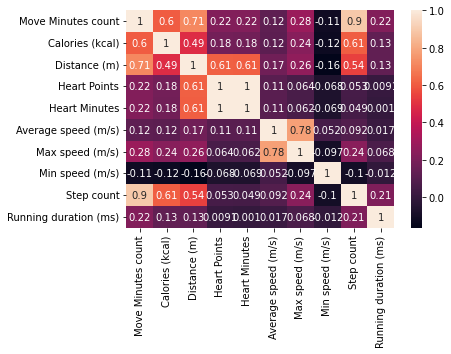

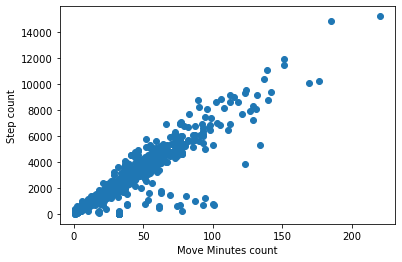

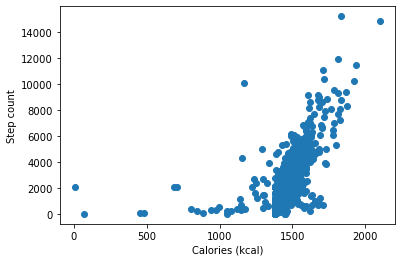

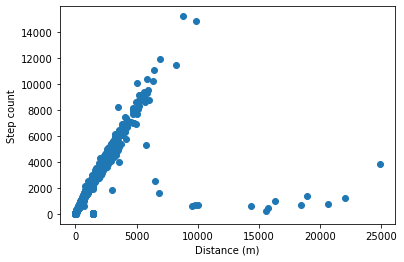

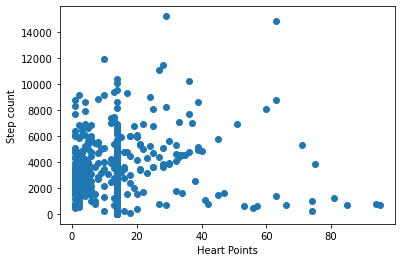

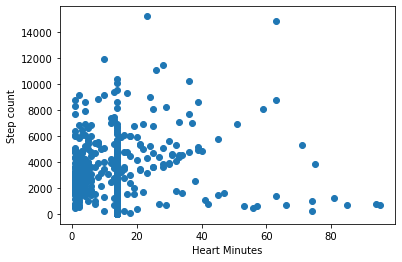

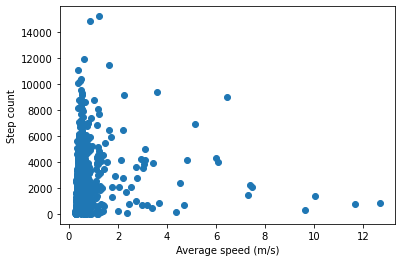

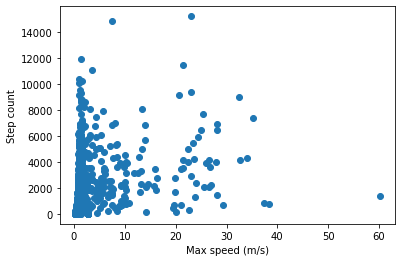

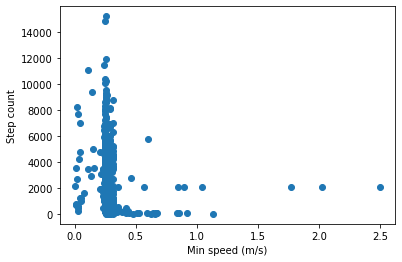

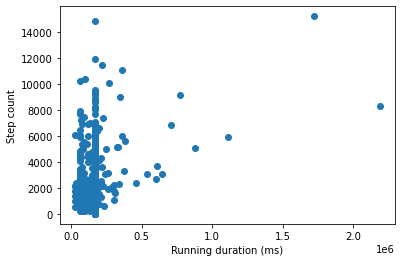

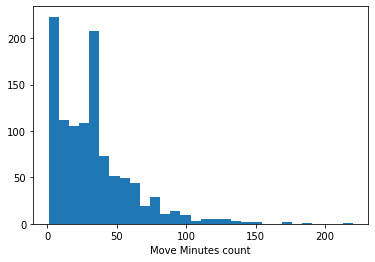

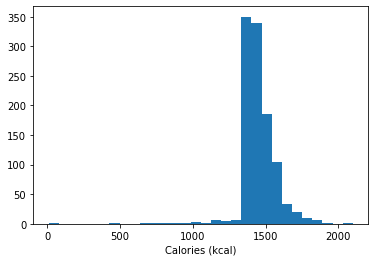

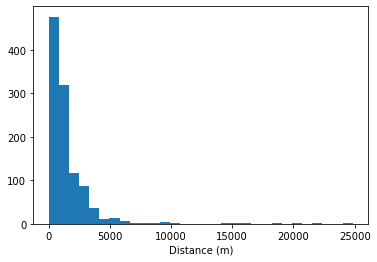

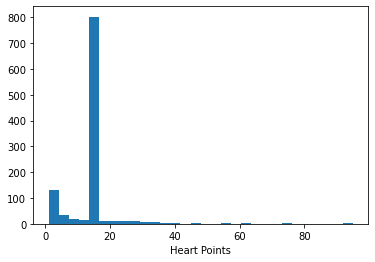

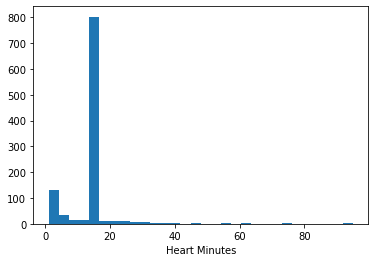

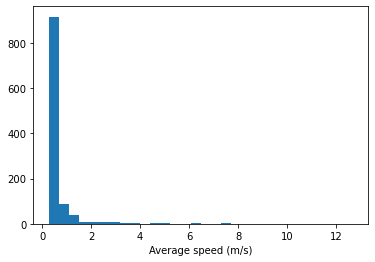

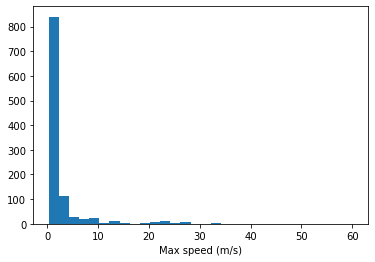

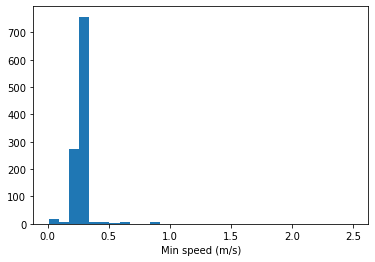

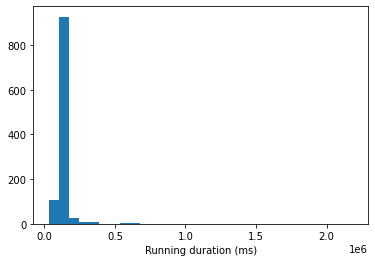

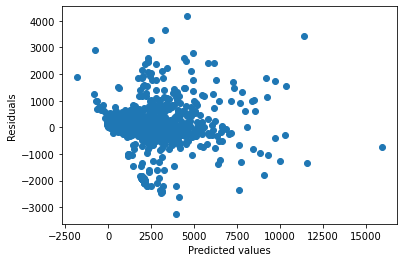

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# Calculate the correlation matrix
corr = df_num.corr()

# Plot the correlation matrix using seaborn
sns.heatmap(corr, annot=True)
plt.show()

# Get the feature columns
features = ['Move Minutes count', 'Calories (kcal)', 'Distance (m)',
           'Heart Points', 'Heart Minutes', 'Average speed (m/s)',
           'Max speed (m/s)', 'Min speed (m/s)', 'Running duration (ms)']

# Split data into independent (X) and dependent (y) variables
X = df_num[features]
y = df_num['Step count']

# Fit a linear regression model to the data
reg = LinearRegression().fit(X, y)

# Check for linearity using scatter plots
for feature in features:
    plt.scatter(df_num[feature], y)
    plt.xlabel(feature)
    plt.ylabel("Step count")
    plt.show()

# Check for normality using histograms
for feature in features:
    plt.hist(df_num[feature], bins=30)
    plt.xlabel(feature)
    plt.show()

# Check for homoscedasticity using residual plots
y_pred = reg.predict(X)
residuals = y - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

# Consider dropping variables that have low correlation with the target variable
# We'll consider variables with correlation less than 0.5 to be low
low_corr_features = []
for feature in features:
    if abs(corr[feature]['Step count']) < 0.5:
        low_corr_features.append(feature)

# Remove the low correlation features from X
X = X.drop(low_corr_features, axis=1)

# Refit the linear regression model to the data
reg = LinearRegression().fit(X, y)


## Observation:
## Step Count is corelated with Move minutes, calroies, Distance and very less corelated with Max speed and Running duration

In [281]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate R-squared
r2 = r2_score(y, y_pred)
print("R-squared:", r2)

# Calculate mean squared error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate mean absolute error
mae = mean_absolute_error(y, y_pred)
print("Mean Absolute Error:", mae)


R-squared: 0.8383523221241578
Mean Squared Error: 693145.5726807778
Root Mean Squared Error: 832.5536455272884
Mean Absolute Error: 510.1229435676817


In [300]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Step count   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1426.
Date:                Sun, 05 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:29:39   Log-Likelihood:                -7099.1
No. Observations:                 868   AIC:                         1.421e+04
Df Residuals:                     864   BIC:                         1.423e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2551.2846    344.573     -7.404      0.000   -3227.582   -1874.987
Move Minutes count    71.9610      1.547     46.513      0.000      68.924      74.998
Distance (m)          -0.2199      0.018    -11.912      0.000      -0.256      -0.184
Calories (kcal)        1.8060      0.252      7.157      0.000       1.311       2.301
==============================================================================
Omnibus:                      211.019   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              745.722
Skew:                          -1.133   Prob(JB):                    1.17e-162
Kurtosis:                       6.936   Cond. No.                     3.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Durbin-Watson  is in the range of 1.5 and 2.5.

In [289]:
df_num.head()

,Date,Move Minutes count,Calories (kcal),Distance (m),Heart Points,Heart Minutes,Average speed (m/s),Max speed (m/s),Min speed (m/s),Step count,Running duration (ms)
0,2020-01-01,32.733471,1222.625041,1462.00347,13.839465,13.759197,0.653860,2.829947,0.279169,2099.64689,166932.702439
1,2020-01-02,32.733471,1387.000000,1462.00347,13.839465,13.759197,0.653860,2.829947,0.279169,2099.64689,166932.702439
2,2020-01-03,32.733471,1386.999892,1462.00347,13.839465,13.759197,0.653860,2.829947,0.279169,2099.64689,166932.702439
3,2020-01-04,32.733471,1386.999878,1462.00347,13.839465,13.759197,0.653860,2.829947,0.279169,2099.64689,166932.702439
4,2020-01-05,14.000000,1405.889189,680.44059,13.839465,13.759197,0.322659,1.762098,0.269038,1421.00000,166932.702439


## Dropping the features which are having high VIF and low corelation

In [8]:
df_num1 = df_num.drop(['Heart Points','Heart Minutes','Average speed (m/s)', 'Max speed (m/s)', 'Min speed (m/s)', 'Running duration (ms)' ], axis=1)

In [9]:
df_num1.head()

,Date,Move Minutes count,Calories (kcal),Distance (m),Step count
0,2020-01-01,32.733471,1222.625041,1462.00347,2099.64689
1,2020-01-02,32.733471,1387.000000,1462.00347,2099.64689
2,2020-01-03,32.733471,1386.999892,1462.00347,2099.64689
3,2020-01-04,32.733471,1386.999878,1462.00347,2099.64689
4,2020-01-05,14.000000,1405.889189,680.44059,1421.00000


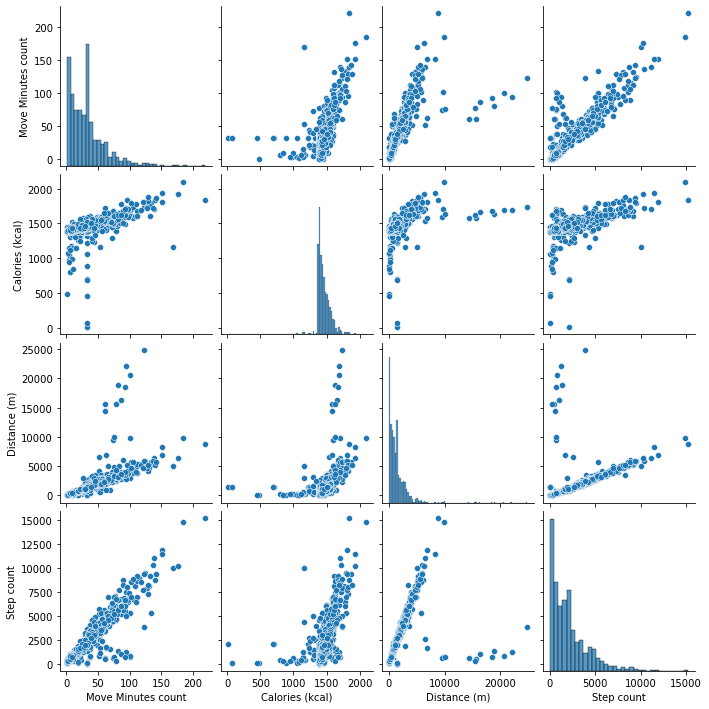

In [292]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df_num1)

In [293]:
df_num1.dtypes

Date                   object
Move Minutes count    float64
Calories (kcal)       float64
Distance (m)          float64
Step count            float64
dtype: object

## Corelation of Step count with other variables

In [297]:
df_num1.corr().iloc[-1]

Move Minutes count    0.895086
Calories (kcal)       0.609074
Distance (m)          0.541200
Step count            1.000000
Name: Step count, dtype: float64

## Fitting model with Variables 'Move Minutes count', 'Calories (kcal)', 'Distance (m)']

In [298]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# select the features to use in the model
features = ['Move Minutes count', 'Calories (kcal)', 'Distance (m)']

# extract the feature data and target data
X = df_num1[features]
y = df_num1['Step count']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# create a linear regression object
regressor = LinearRegression()

# fit the model to the training data
regressor.fit(X_train, y_train)

# make predictions on the test data
y_pred = regressor.predict(X_test)

# calculate the R^2 score
r2 = r2_score(y_test, y_pred)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# calculate the root mean squared error
rmse = np.sqrt(mse)

# calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# calculate the partial R squared for each feature
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
partial_r2 = [r2 * (1 - vif_i / (1 + vif_i)) for vif_i in vif]

# print the evaluation metrics
print("R^2 score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
#print("F1 score:", f1)
print("Partial R^2:", partial_r2)


R^2 score: 0.8163831883908516
Mean Squared Error: 684649.316421171
Root Mean Squared Error: 827.4353850429476
Mean Absolute Error: 505.09984310870186
Partial R^2: [0.13531741201553754, 0.22134752117664966, 0.20391738263935322]


# Observation: 

## From Partial R sq, Move minutes contributes the least, it need not be high inorder to burn calories because in shorter duration one can run or bresk walk that makes the Variable "Move minutes" not being contributing. 

## It may indicate that while walking and talking on phone the calories burnt are not high however only distance is contributing to step count.

## Perform forward feature selection

In [304]:
X = df_num1[['Move Minutes count']]
y = df_num1['Step count']

X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Step count   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     4368.
Date:                Sun, 05 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:41:46   Log-Likelihood:                -8956.2
No. Observations:                1086   AIC:                         1.792e+04
Df Residuals:                    1084   BIC:                         1.793e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -48.1631     42

In [305]:
X = df_num1[['Move Minutes count', 'Calories (kcal)']]
y = df_num1['Step count']

X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Step count   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     2291.
Date:                Sun, 05 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:42:27   Log-Likelihood:                -8934.9
No. Observations:                1086   AIC:                         1.788e+04
Df Residuals:                    1083   BIC:                         1.789e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2336.2933    350

## No Change in R square on adding Calories (kcal)

In [303]:
X = df_num1[['Calories (kcal)', 'Distance (m)']]
y = df_num1['Step count']

X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Step count   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     442.8
Date:                Sun, 05 Feb 2023   Prob (F-statistic):          2.94e-141
Time:                        14:41:27   Log-Likelihood:                -9508.8
No. Observations:                1086   AIC:                         1.902e+04
Df Residuals:                    1083   BIC:                         1.904e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -8496.6081    560.975    -

In [301]:
import statsmodels.api as sm

X = df_num1[['Move Minutes count', 'Calories (kcal)', 'Distance (m)']]
y = df_num1['Step count']

X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Step count   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     1755.
Date:                Sun, 05 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:35:53   Log-Likelihood:                -8872.7
No. Observations:                1086   AIC:                         1.775e+04
Df Residuals:                    1082   BIC:                         1.777e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2775.2888    333

## R square increased from 0.8 to 0.83 on adding 'Calories (kcal)', 'Distance (m)'

## Analysis/Checking of Linear Regression Assumptions:

In [306]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train,y_train)

LinearRegression()

## 1. Linearity

In [307]:
# Residual
y_pred = model.predict(X_test)
residual = y_test - y_pred

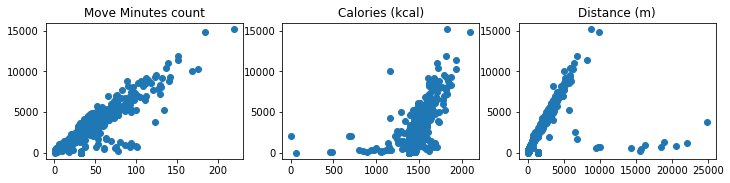

In [309]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 2.5))

ax1.scatter(df_num1['Move Minutes count'], df_num1['Step count'])
ax1.set_title("Move Minutes count")
ax2.scatter(df_num1['Calories (kcal)'], df_num1['Step count'])
ax2.set_title("Calories (kcal)")
ax3.scatter(df_num1['Distance (m)'], df_num1['Step count'])
ax3.set_title("Distance (m)")

plt.show()

## 2. Multicollinearity

In [336]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = df_num[['Calories (kcal)', 'Move Minutes count', 'Distance (m)', 'Step count']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

              feature        VIF
0     Calories (kcal)   2.692874
1  Move Minutes count  18.498201
2        Distance (m)   3.295540
3          Step count  11.180652


<AxesSubplot:>

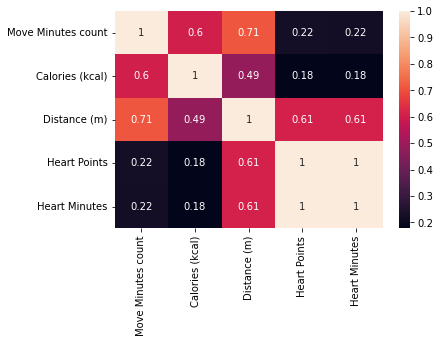

In [320]:
# Another Technique
sns.heatmap(df_num1.iloc[:,0:6].corr(),annot=True)

## 3. Normality of Residual

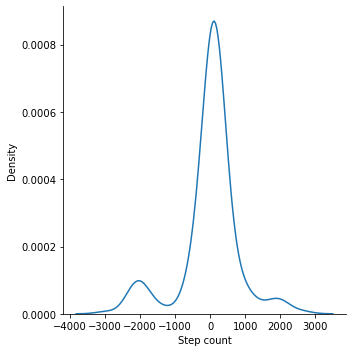

In [321]:
sns.displot(residual,kind='kde')

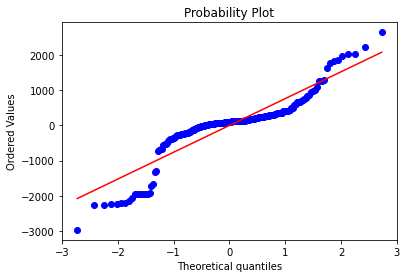

In [322]:
# QQ Plot

import scipy as sp

fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual, plot=ax, fit=True)

plt.show()

## 4. Homoscedasticity

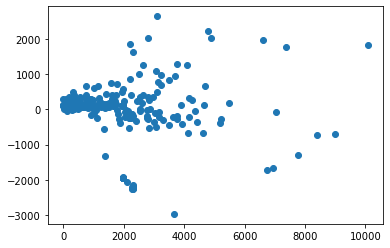

In [323]:
plt.scatter(y_pred,residual)

## 5. Autocorrelation of Residuals

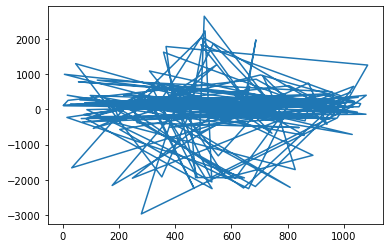

In [324]:
plt.plot(residual)

## Scope for improvement in this project:
    
#### In this analysis I have analysed by taking variables with are having fair corelation with target, however there can be few variables which may have causal relation (non-linear)

#### Transforming variables for adhereing Linear Regression

#### Searching for hidden pattern in the data by bringing Time(Date) in the analysis.

### Not all times LR assumptions need to be true this can be a case where we are ok with the data not adhereing LR assumptions and results making sense.

In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

# Load the data
#df_num1 = pd.read_csv("data.csv")

# Select the predictors and target variables
X = df_num1[['Move Minutes count', 'Calories (kcal)', 'Distance (m)']]
y = df_num1['Step count']

# Fit a linear regression model to the data
reg = LinearRegression().fit(X, y)

# Perform the partial F test
F_values, p_values = f_regression(X, y)

# Print the F values and p values
print("F values:", F_values)
print("p values:", p_values)


F values: [4368.11487723  639.29027673  449.01611978]
p values: [0.00000000e+000 3.01007787e-111 1.17369542e-083]


we can see that all three predictors have F values greater than 0 and p values less than 0.05, indicating that all three predictors are significant in explaining the target variable Step count.